In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import glob

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
sharedFolder = '/work/group/egodat/reu23_clark/'
dataFolder = sharedFolder + 'data/'

# Load data

## Shape Files

In [3]:
#Load Core Based Statistical Areas (https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-metropolitan-statistical-area-micropolitan-statist)
#CRS 3857: https://epsg.io/3857

CBSAs = geopandas.read_file(dataFolder + "tl_2019_us_cbsa.zip").to_crs(3857)
CBSAs = CBSAs[['CBSAFP', 'NAME', 'geometry']]
CBSAs['CBSAFP'] = CBSAs['CBSAFP'].astype(int)
CBSAs.rename(columns={'CBSAFP': 'CBSA'}, inplace=True)
CBSAs

,CBSA,NAME,geometry
0,12020,"Athens-Clarke County, GA","POLYGON ((-9299339.399 4024225.385, -9298722.4..."
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","POLYGON ((-9499808.416 3982318.514, -9499830.0..."
2,12100,"Atlantic City-Hammonton, NJ","POLYGON ((-8333014.948 4782122.394, -8333009.7..."
3,12120,"Atmore, AL","POLYGON ((-9753303.463 3638074.432, -9753303.2..."
4,12140,"Auburn, IN","POLYGON ((-9483635.192 5068556.085, -9483636.4..."
...,...,...,...
933,49060,"Winfield, KS","POLYGON ((-10814782.844 4481524.994, -10814783..."
934,49080,"Winnemucca, NV","POLYGON ((-13233024.775 5006594.818, -13233215..."
935,49100,"Winona, MN","POLYGON ((-10250133.062 5468589.383, -10250142..."
936,49180,"Winston-Salem, NC","POLYGON ((-8955841.577 4336663.225, -8955841.5..."


In [4]:
statesShp = geopandas.read_file(dataFolder + "cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

# contUS = ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
# statesShp = statesShp[statesShp['STUSPS'].isin(contUS)] #Only use continental US

def plotUS():
    ax = statesShp.plot(figsize=(20, 10))
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

In [12]:
year = '2021'

## Load Internet Speed Data
Takes some time. Skip if result is already saved in sharedFolder/data/internet_speed.pkl

In [ ]:
gdf = geopandas.read_file(dataFolder + "internet_speed/" + year + "-q1/gps_fixed_tiles.shp").to_crs(3857)
gdf.to_pickle(dataFolder + "internet_speed/" + year + "-q1/gps_fixed_tiles_shp.pkl")
print('.')
gdf = geopandas.read_file(dataFolder + "internet_speed/" + year + "-q2/gps_fixed_tiles.shp").to_crs(3857)
gdf.to_pickle(dataFolder + "internet_speed/" + year + "-q2/gps_fixed_tiles_shp.pkl")
print('.')
gdf = geopandas.read_file(dataFolder + "internet_speed/" + year + "-q3/gps_fixed_tiles.shp").to_crs(3857)
gdf.to_pickle(dataFolder + "internet_speed/" + year + "-q3/gps_fixed_tiles_shp.pkl")
print('.')
gdf = geopandas.read_file(dataFolder + "internet_speed/" + year + "-q4/gps_fixed_tiles.shp").to_crs(3857)
gdf.to_pickle(dataFolder + "internet_speed/" + year + "-q4/gps_fixed_tiles_shp.pkl")

speedDataq1 = pd.read_pickle(dataFolder + "internet_speed/" + year + "-q1/gps_fixed_tiles_shp.pkl")
speedDataq2 = pd.read_pickle(dataFolder + "internet_speed/" + year + "-q2/gps_fixed_tiles_shp.pkl")
speedDataq3 = pd.read_pickle(dataFolder + "internet_speed/" + year + "-q3/gps_fixed_tiles_shp.pkl")
speedDataq4 = pd.read_pickle(dataFolder + "internet_speed/" + year + "-q4/gps_fixed_tiles_shp.pkl")

speedData = pd.concat([speedDataq1, speedDataq2, speedDataq3, speedDataq4])
speedData = speedData[['avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'geometry']]

speedData

In [ ]:
speedData['geometry'] = speedData.centroid #Regions are small enough to treat as a point (also good for speed)

In [ ]:
#Get CBSA for each point
speedData = geopandas.sjoin(speedData, CBSAs)
speedData

In [ ]:
speedData.to_pickle(dataFolder + "internet_speed/data" + year + ".pkl")

# Analysis

In [13]:
speedData = pd.read_pickle(dataFolder + "internet_speed/data" + year + ".pkl")

In [14]:
#Compute weighted average speed for all points in a CBSA
speedData['u_kbps_scaled'] = speedData['avg_u_kbps'] * speedData['devices']
speedData['d_kbps_scaled'] = speedData['avg_d_kbps'] * speedData['devices']
speedByCBSA = speedData.groupby(by='CBSA').sum()
speedByCBSA['avg_u_kbps'] = speedByCBSA['u_kbps_scaled'] / speedByCBSA['devices']
speedByCBSA['avg_d_kbps'] = speedByCBSA['d_kbps_scaled'] / speedByCBSA['devices']
speedByCBSA = speedByCBSA.drop(columns=['u_kbps_scaled', 'd_kbps_scaled'])

gdf = pd.merge(CBSAs, speedByCBSA, on='CBSA')
gdf

,CBSA,NAME,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,index_right
0,12020,"Athens-Clarke County, GA","POLYGON ((-9299339.399 4024225.385, -9298722.4...",151937.701735,41624.537882,189898,35167,12737,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","POLYGON ((-9499808.416 3982318.514, -9499830.0...",205488.114906,82655.859473,2687156,1465131,458176,112890
2,12100,"Atlantic City-Hammonton, NJ","POLYGON ((-8333014.948 4782122.394, -8333009.7...",213254.557135,21587.345600,87871,51529,15761,9634
3,12120,"Atmore, AL","POLYGON ((-9753303.463 3638074.432, -9753303.2...",96660.075505,16978.787753,116628,5013,1682,2841
4,12140,"Auburn, IN","POLYGON ((-9483635.192 5068556.085, -9483636.4...",134945.971817,45009.268591,70500,9178,2945,4916
...,...,...,...,...,...,...,...,...,...
933,49060,"Winfield, KS","POLYGON ((-10814782.844 4481524.994, -10814783...",121050.135994,19912.459719,32289,4817,1353,735204
934,49080,"Winnemucca, NV","POLYGON ((-13233024.775 5006594.818, -13233215...",67338.556338,11607.729376,18840,3596,994,400686
935,49100,"Winona, MN","POLYGON ((-10250133.062 5468589.383, -10250142...",118909.496792,30872.018237,41091,9030,2961,1206150
936,49180,"Winston-Salem, NC","POLYGON ((-8955841.577 4336663.225, -8955841.5...",184031.243746,48710.074255,442003,159664,51525,19451952


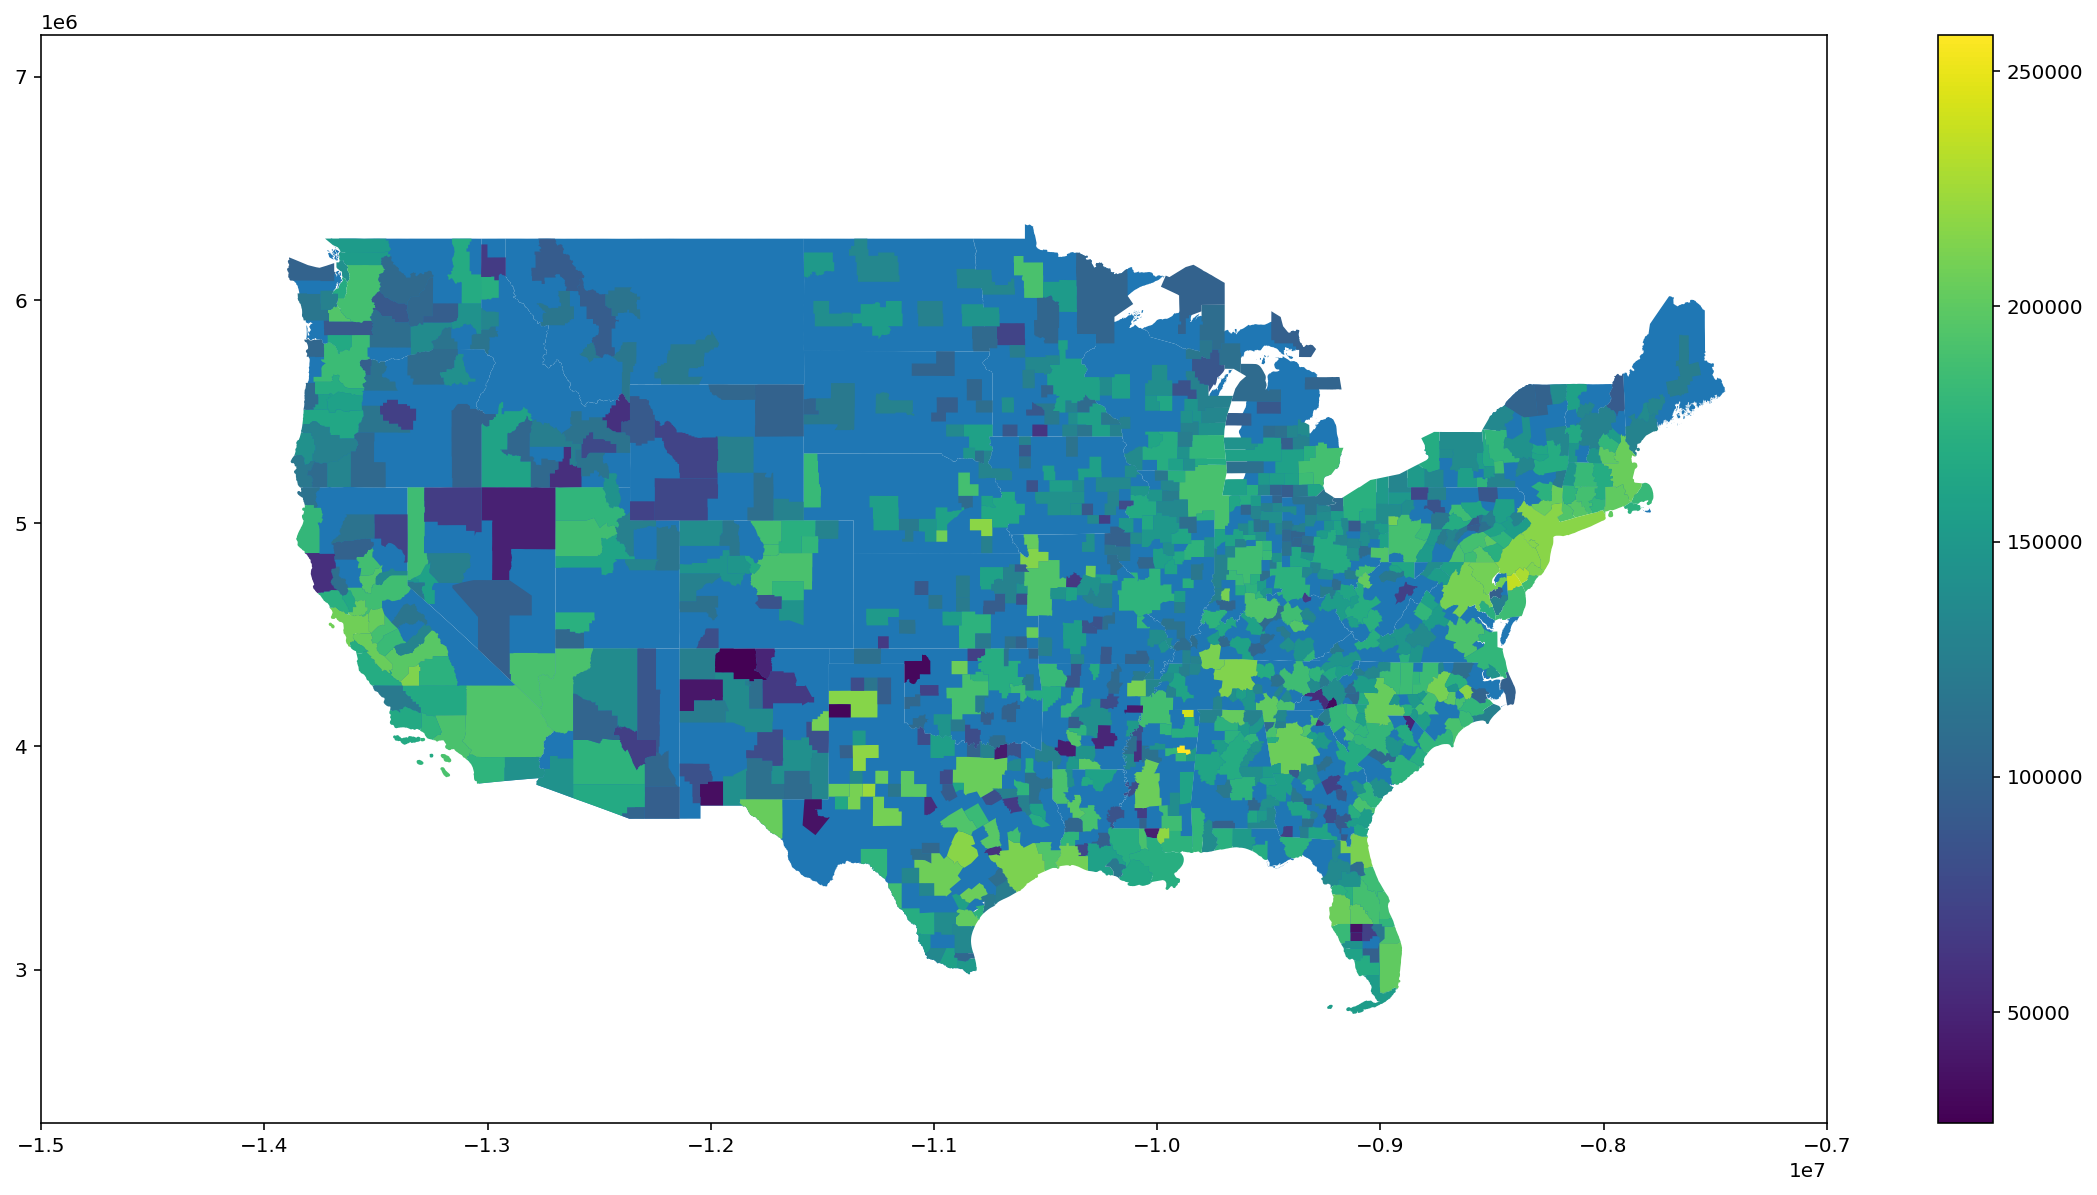

In [15]:
ax = plotUS()
gdf.plot(ax=ax, column='avg_d_kbps', legend=True);

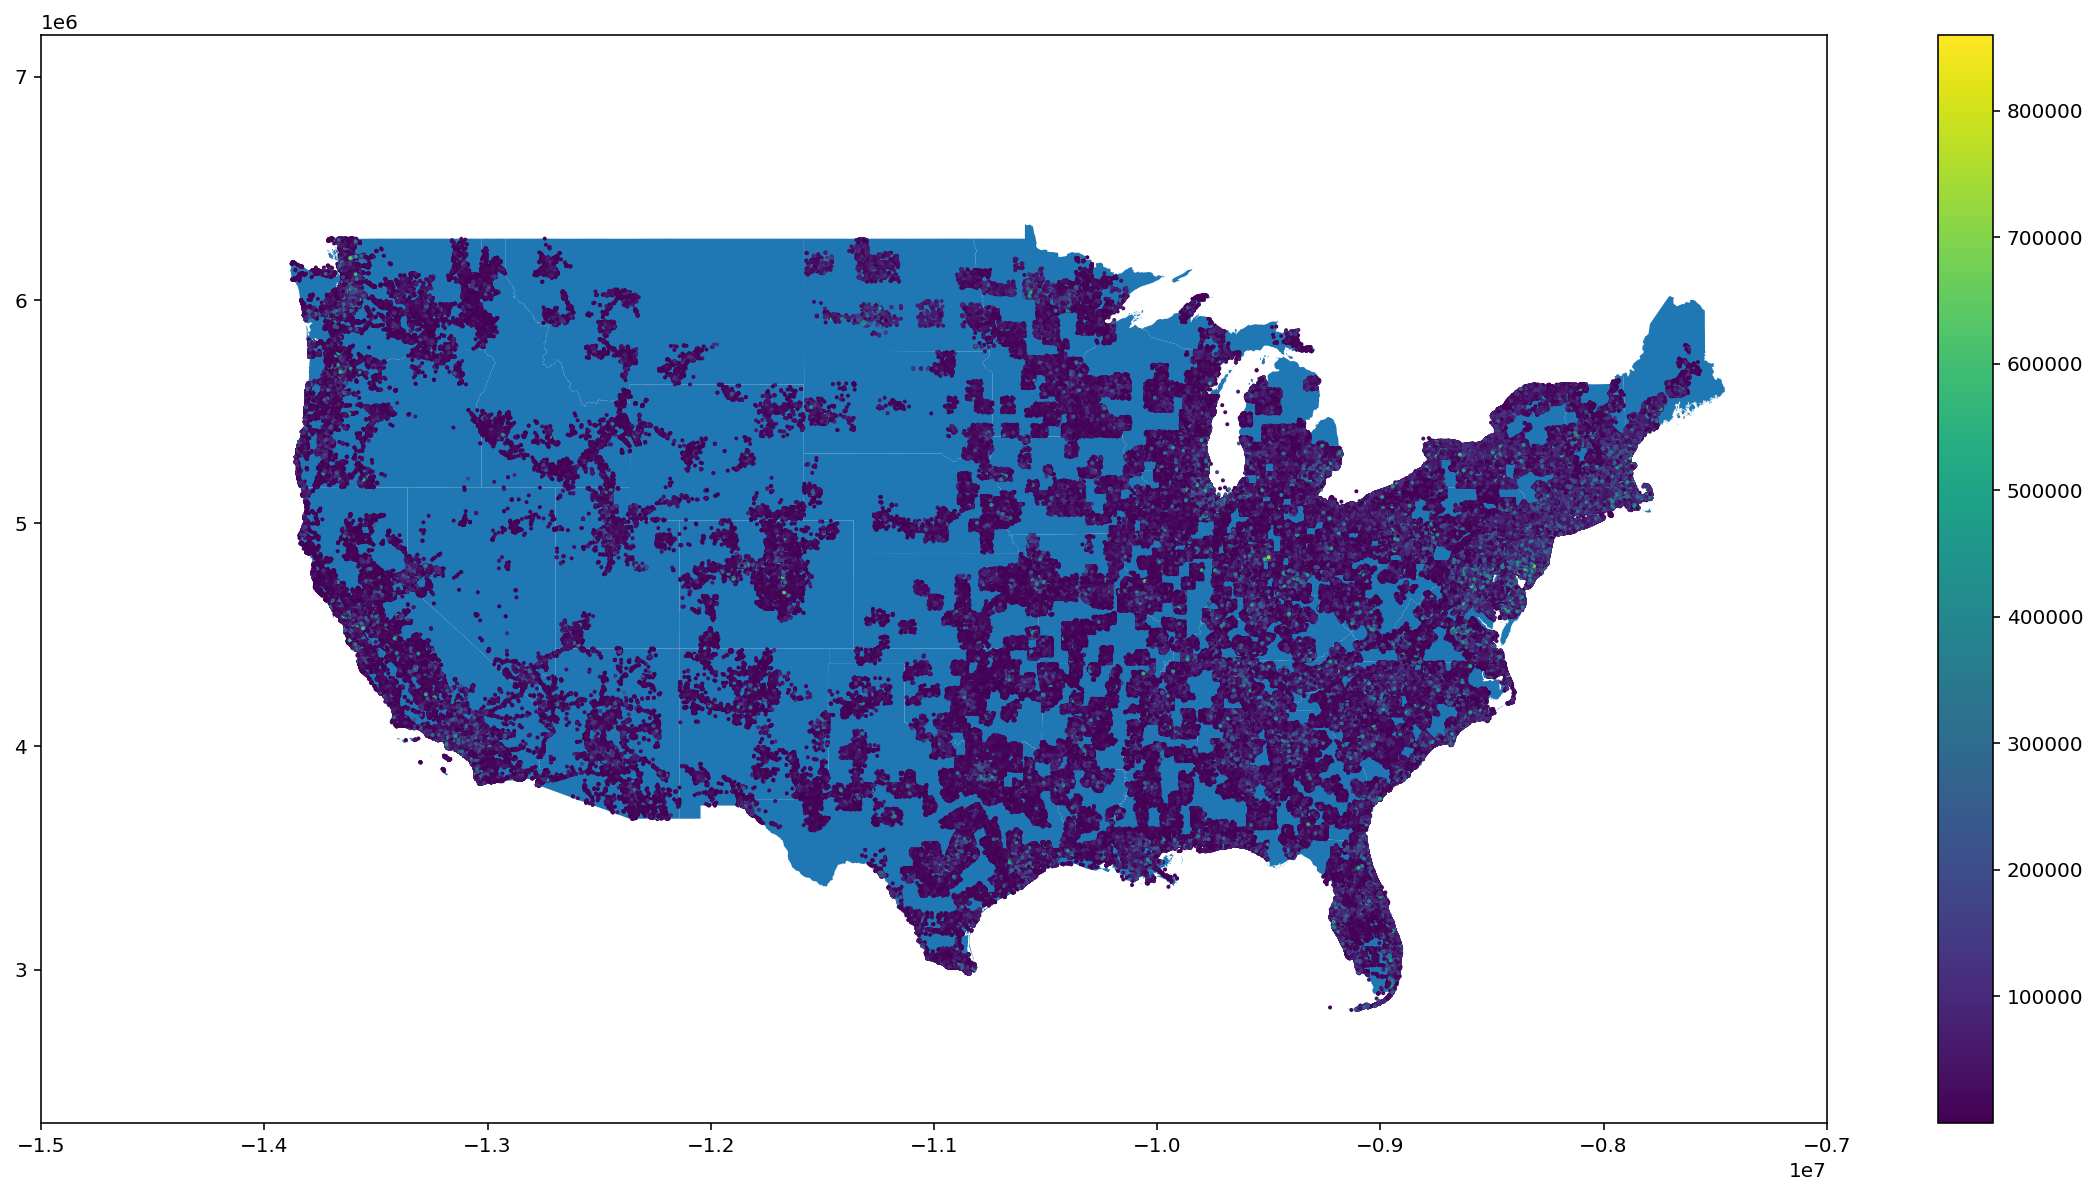

In [9]:
ax = plotUS()
speedData.plot(ax=ax, column='avg_d_kbps', marker='o', markersize=1, legend=True);

In [16]:
gdf.to_pickle(dataFolder + "internet_speed/speedByCbsa" + year + ".pkl")